# Networks

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class DQN(torch.nn.Module):
    def __init__(self):
        super(DQN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=4, out_channels=32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1)
        self.fc1 = torch.nn.Linear(in_features=64 * 7 * 7, out_features=512)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.fc1(x.flatten(1)))
        return x


class TransferDQN(torch.nn.Module):
    def __init__(self, action_space_size, DQN):
        super(TransferDQN, self).__init__()
        self.DQN = DQN
        self.output_layer = torch.nn.Linear(in_features=512, out_features=action_space_size)

    def forward(self, x):
        x = self.DQN(x)
        x = self.output_layer(x)
        return x

# Wrappers

In [ ]:
import cv2
import gym
import numpy as np

def resize_frame(frame):
    frame = frame[30:-12, 5:-4]
    frame = cv2.resize(frame, (84, 84), interpolation=cv2.INTER_NEAREST)
    frame = np.array(frame, dtype=np.uint8)
    return frame


class MapState(gym.ObservationWrapper):
    def __init__(self, env, map_func):
        gym.ObservationWrapper.__init__(self, env)
        self._func = map_func

    def observation(self, obs):
        return self._func(obs)

# Agent

In [ ]:
!pip install gym-notebook-wrapper

In [ ]:
!apt update && apt install xvfb

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Get:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release [564 B]
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release.gpg [833 B]
Hit:10 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:11 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]


In [ ]:
import os
import time
import random

import gym
import gnwrapper
import torch
import numpy as np

from gym.wrappers.gray_scale_observation import GrayScaleObservation
from gym.wrappers.frame_stack import FrameStack

from collections import deque


class Agent:
    def __init__(self, DQN=DQN(), discount_factor=0.99, num_learning_for_update=10_000,
                 game_id='PongDeterministic-v4', first_random_states=50_000,
                 action_space=[0, 2, 3], project_path=".", num_stack=120_000,
                 num_episodes_to_save_model=10, load=False):
      
        self.project_path = project_path
        self.dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        self.states_perform = 0
        self.memory = deque(maxlen=num_stack)
        self.eval = False
        self.env = self.load_enviroment(game_id)
        self.num_stack = num_stack
        self.learning = 0
        self.current_episode = 1


        # networks
        self.action_space = action_space
        self.policy_network = TransferDQN(len(action_space), DQN).to(self.dev)
        self.target_network = TransferDQN(len(action_space), DQN).to(self.dev)
        if load:
            self.policy_network.load_state_dict(torch.load(os.path.join(self.project_path, 'last_model_weights')))
        self.target_network.load_state_dict(self.policy_network.state_dict())
        self.target_network.eval()

        # factors
        self.discount_factor = discount_factor
        self.num_learning_for_update = num_learning_for_update
        self.num_episodes_to_save_model = num_episodes_to_save_model
        self.random_factor = 1
        self.random_factor_discount = 1e-06
        self.minimum_random_factor = .05
        self.batch_size = 32
        self.first_random_frames = first_random_states

        self.optimizer = torch.optim.RMSprop(self.policy_network.parameters(), lr=0.0001)
        self.criterion = torch.nn.SmoothL1Loss()
        self.scores = deque(maxlen=100)
        self.max_score = -21
        self.summary = []

    def train(self, num_episodes, debug=False):
        for episode in range(self.current_episode, num_episodes + 1):
            start_time = time.time()
            print(f"Starting game {episode}")
            score, steps = self.play_single_game(debug)

            end_time = time.time()
            self.scores.append(score)
            if episode % self.num_episodes_to_save_model == 0:
                self.save_model()
            if score > self.max_score:
                self.max_score = score
            self.summary.append([episode, score, steps])
            print(f"score: {score}\ntime: {end_time - start_time}\nsteps: {steps}\nmax score: {self.max_score}"
                  f"\nrandom factor: {self.random_factor}\n")
            if episode % 100 == 0:
                print(f"Average result is {sum(self.scores) / len(self.scores)}")
            self.current_episode += 1

    def play_single_game(self, debug):
        current_state = self.env.reset()
        current_state = torch.tensor(current_state).reshape(1, 4, 84, -1).type(torch.float).to(self.dev)
        score = 0
        steps = 0
        is_done = False
        while not is_done:
            steps += 1
            self.states_perform += 1
            action, reward, next_step, is_done = self.preform_next_step(current_state, debug=debug)
            score += reward
            self.memory.append((current_state, action, reward, next_step, is_done))
            current_state = next_step
            if self.states_perform > self.first_random_frames:
                self.update_policy()
        return score, steps

    def preform_next_step(self, current_state, eval=False, debug=False):
        random_choice_probability = random.uniform(0, 1)
        if random_choice_probability > self.random_factor:
            with torch.no_grad():
                if debug:
                    start = time.time()
                actions_q_value = self.policy_network(current_state)
                if debug:
                    print(actions_q_value)
                action = torch.argmax(actions_q_value).item()
                selected_action = self.action_space[action]
                if debug:
                    end = time.time()
                    print(end - start)
        else:
            action = random.sample(range(len(self.action_space)), k=1)[0]
            selected_action = self.action_space[action]
        next_step, reward, is_done, info = self.env.step(selected_action)
        next_step = torch.from_numpy(np.stack(next_step).reshape(1, 4, 84, 84)).type(torch.float).to(self.dev)
        return action, reward, next_step, is_done

    def update_policy(self):
        self.learning += 1
        self.random_factor = self.random_factor - self.random_factor_discount \
            if self.random_factor > self.minimum_random_factor \
            else self.random_factor
        state, actions, reward, next_state, is_done = self.get_batch()
        state_label = torch.zeros(self.batch_size).to(self.dev)
        is_done_mask = is_done == True
        is_not_done_mask = torch.logical_not(is_done_mask)
        state_label[is_done_mask] = reward[is_done_mask]
        with torch.no_grad():
            actions_q_value = torch.max(self.target_network(next_state[is_not_done_mask]), dim=1)
        state_label[is_not_done_mask] = reward[is_not_done_mask] + (
                self.discount_factor * actions_q_value.values).reshape(-1)
        predictions = self.policy_network(state).gather(1, actions.reshape(-1, 1)).reshape(-1)
        self.optimizer.zero_grad()
        loss = self.criterion(predictions, state_label)
        loss.backward()
        self.optimizer.step()

        if self.learning % self.num_learning_for_update == 0:
            print(f"Updating target network number of frames = {self.states_perform}")
            self.update_target_weights()

    def get_batch(self):
        # current_state : Tensor [batch_size, k_frames, height, width]
        # action : Tensor [batch_size, 1]
        # reward: Tensor[batch_size, 1]
        # next_state : Tensor [batch_size, k_frames, height, width]
        # is_done : Tensor [batch_size, 1]
        # current_state, action, reward, next_step, is_done

        result = {}
        batch = random.sample(self.memory, self.batch_size)
        for i in range(5):
            result[i] = list(map(lambda x: x[i], batch))
        return torch.cat(result[0]),\
         torch.tensor(result[1]).to(self.dev),\
         torch.tensor(result[2]).to(self.dev),\
         torch.cat(result[3]),\
         torch.tensor(result[2])

    def update_target_weights(self):
        self.target_network.load_state_dict(self.policy_network.state_dict())

    def load_enviroment(self, game_id, frame_history=4):
        env = gym.make(game_id)
        if self.eval:
          env = gnwrapper.Monitor(env,directory=os.path.join(self.project_path, 'videos'), force=True)
        env = MapState(env, lambda im: resize_frame(im))
        env = GrayScaleObservation(env)
        env = FrameStack(env, frame_history)
        return env

    def save_model(self, path="last_model_weights"):
        weight_path = os.path.join(self.project_path, path)
        torch.save(self.policy_network.state_dict(), weight_path)

    @torch.no_grad()
    def eval_model(self):
        self.policy_network.eval()
        temp_factor = self.random_factor
        self.random_factor = self.minimum_random_factor
        current_state = self.env.reset()
        current_state = torch.from_numpy(np.stack(current_state).reshape(1, 4, 84, 84)).type(torch.float).to(self.dev)
        done = False
        score = 0
        step = 0
        while not done:
            step += 1
            _, reward, current_state, done = self.preform_next_step(current_state, eval=True)
            score += reward
        print(step)
        print(score)
        self.random_factor = temp_factor
        self.policy_network.train()

# Main

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

project_path = '/content/gdrive/MyDrive/Deep Learning Project'

Mounted at /content/gdrive


In [ ]:
%%time
import dill

LOAD_AGENT = True
EPISODES = 2000
EVAL = True

agent_path = os.path.join(project_path, 'Agent_pong')
if LOAD_AGENT:
  print("Loading agent")
  with open(agent_path, 'rb') as f:
    atari_agent = dill.load(f)
    atari_agent.states_perform = 0
else:
  atari_agent = Agent(load=False, project_path=project_path)
if EVAL:
  atari_agent.eval = True
  atari_agent.env = atari_agent.load_enviroment('PongDeterministic-v4')
  atari_agent.eval_model()
  atari_agent.env.display()
  atari_agent.env.close()
else:
  done = False
  try:
    atari_agent.train(EPISODES, debug=False)
    done = True
  except KeyboardInterrupt:
    with open(agent_path, 'wb') as f:
      atari_agent.memory = deque(maxlen=atari_agent.num_stack)
      print("Saving agent")
      dill.dump(atari_agent, f)
  if done:
      with open(agent_path, 'wb') as f:
        atari_agent.memory = deque(maxlen=atari_agent.num_stack)
        print("Saving agent")
        dill.dump(atari_agent, f)

Loading agent
2223
18.0


'openaigym.video.0.61.video000000.mp4'

CPU times: user 6.49 s, sys: 1.34 s, total: 7.83 s
Wall time: 18.2 s


# Statistics

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
episodes_list = list(map(lambda x: x[0], atari_agent.summary))
scores_list = list(map(lambda x: x[1], atari_agent.summary))
steps_list = list(map(lambda x: x[2], atari_agent.summary))

In [ ]:
window_size = 100
windows = int(len(scores_list) / window_size)

In [ ]:
average_scores_list = []
average_steps_list = []
for i in range(windows):
  average_scores_list.append(sum(scores_list[(i * window_size):((i + 1) * window_size)]) / window_size)
  average_steps_list.append(sum(steps_list[(i * window_size):((i + 1) * window_size)]) / window_size)

In [ ]:
windows_list = [i for i in range(window_size, len(atari_agent.summary) + 1,window_size)]

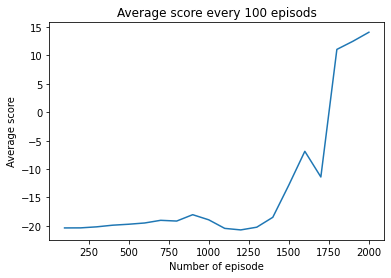

In [ ]:
plt.plot(windows_list, average_scores_list) 
plt.xlabel('Number of episode') 
plt.ylabel('Average score') 
plt.title(f"Average score every {window_size} episods")
plt.show()

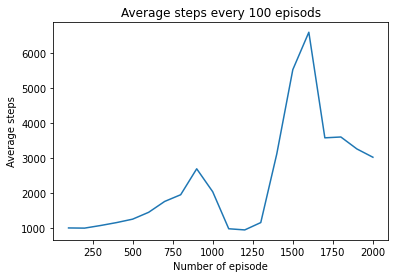

In [ ]:
plt.plot(windows_list, average_steps_list) 
plt.xlabel('Number of episode') 
plt.ylabel('Average steps') 
plt.title(f"Average steps every {window_size} episods")
plt.show()